In [3]:
# GENERICOS
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# DECOMPOSE
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

# TESTS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# MODELOS
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# WARNINGS
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import InterpolationWarning
simplefilter('ignore', category=ConvergenceWarning)
simplefilter('ignore', category=FutureWarning)
simplefilter('ignore', category=InterpolationWarning)

In [4]:
df_base = pd.read_csv('../data/processed/data_processed_1990_2023.csv', index_col='fecha')
df_base.drop('target', axis=1, inplace=True)
df_base.index = pd.to_datetime(df_base.index)
df_base.tail(7)

,tmin,tmax,tmed,presMin,presMax,dir,velmedia,racha,sol,prec
fecha,,,,,,,,,,
2023-03-06,10.3,15.9,13.1,1008.7,1013.4,21.0,1.9,8.3,0.0,3.3
2023-03-07,12.9,19.7,16.3,1009.8,1013.4,22.0,3.9,10.3,3.2,0.6
2023-03-08,14.4,20.5,17.4,1011.6,1015.1,22.0,6.1,10.3,3.2,2.5
2023-03-09,13.6,20.5,17.0,1013.7,1019.5,21.0,5.3,12.5,3.0,0.9
2023-03-10,8.9,21.8,15.4,1019.2,1022.5,99.0,1.7,6.7,10.5,0.1
2023-03-11,8.9,24.0,16.4,1018.7,1022.2,99.0,2.8,7.8,9.9,0.0
2023-03-12,9.5,26.5,18.0,1014.1,1020.3,8.0,2.2,8.3,10.6,0.0


In [5]:
df_last_year = df_base.iloc[-365:]
df_last_year.head()

,tmin,tmax,tmed,presMin,presMax,dir,velmedia,racha,sol,prec
fecha,,,,,,,,,,
2022-03-13,11.0,18.1,14.6,1006.7,1013.8,21.0,1.7,7.8,6.8,12.7
2022-03-14,10.1,14.7,12.4,999.7,1006.7,99.0,4.7,13.9,0.9,1.0
2022-03-15,10.7,16.0,13.4,1002.8,1008.5,7.0,2.8,16.4,0.0,6.4
2022-03-16,11.7,13.5,12.6,1005.8,1012.2,8.0,1.1,9.7,0.0,2.9
2022-03-17,11.1,18.4,14.8,1011.3,1016.7,6.0,3.6,10.3,0.0,0.0


- Trabajamos con TMED

In [6]:
tmed = df_base['tmed']
tmed_last_year = df_last_year['tmed']

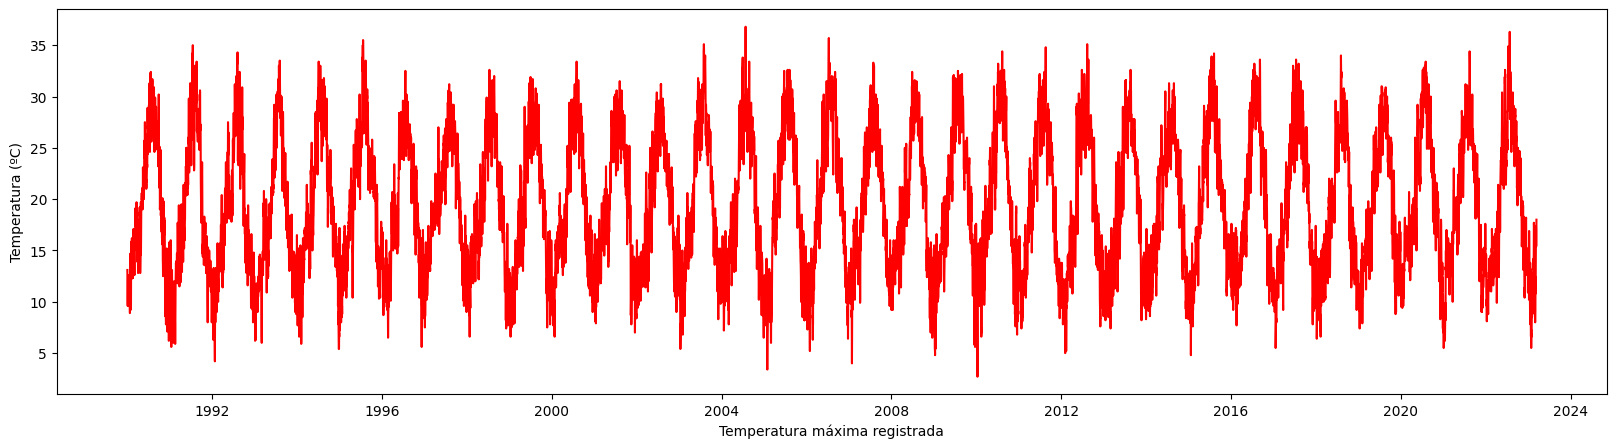

In [7]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(tmed, color='red')
ax.set_xlabel('Temperatura máxima registrada')
ax.set_ylabel('Temperatura (ºC)')
plt.show()

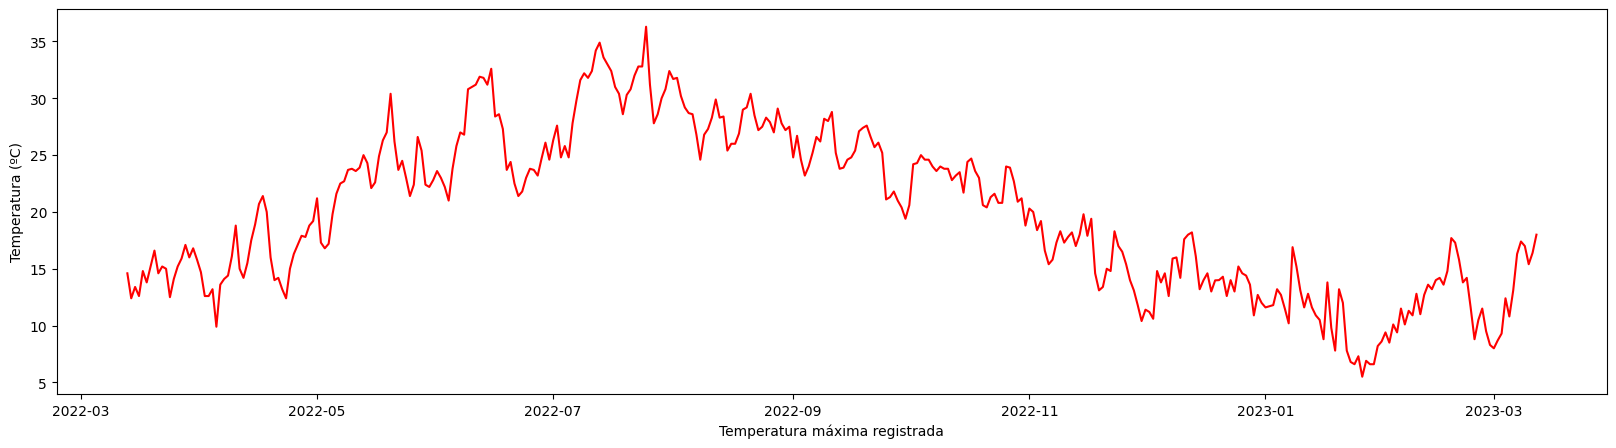

In [8]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(tmed_last_year, color='red')
ax.set_xlabel('Temperatura máxima registrada')
ax.set_ylabel('Temperatura (ºC)')
plt.show()

Veamos la descomposición en los ultimos 365 días para más claridad.

Dado que la magnitud no cambia con el tiempo, usamos la aditiva.

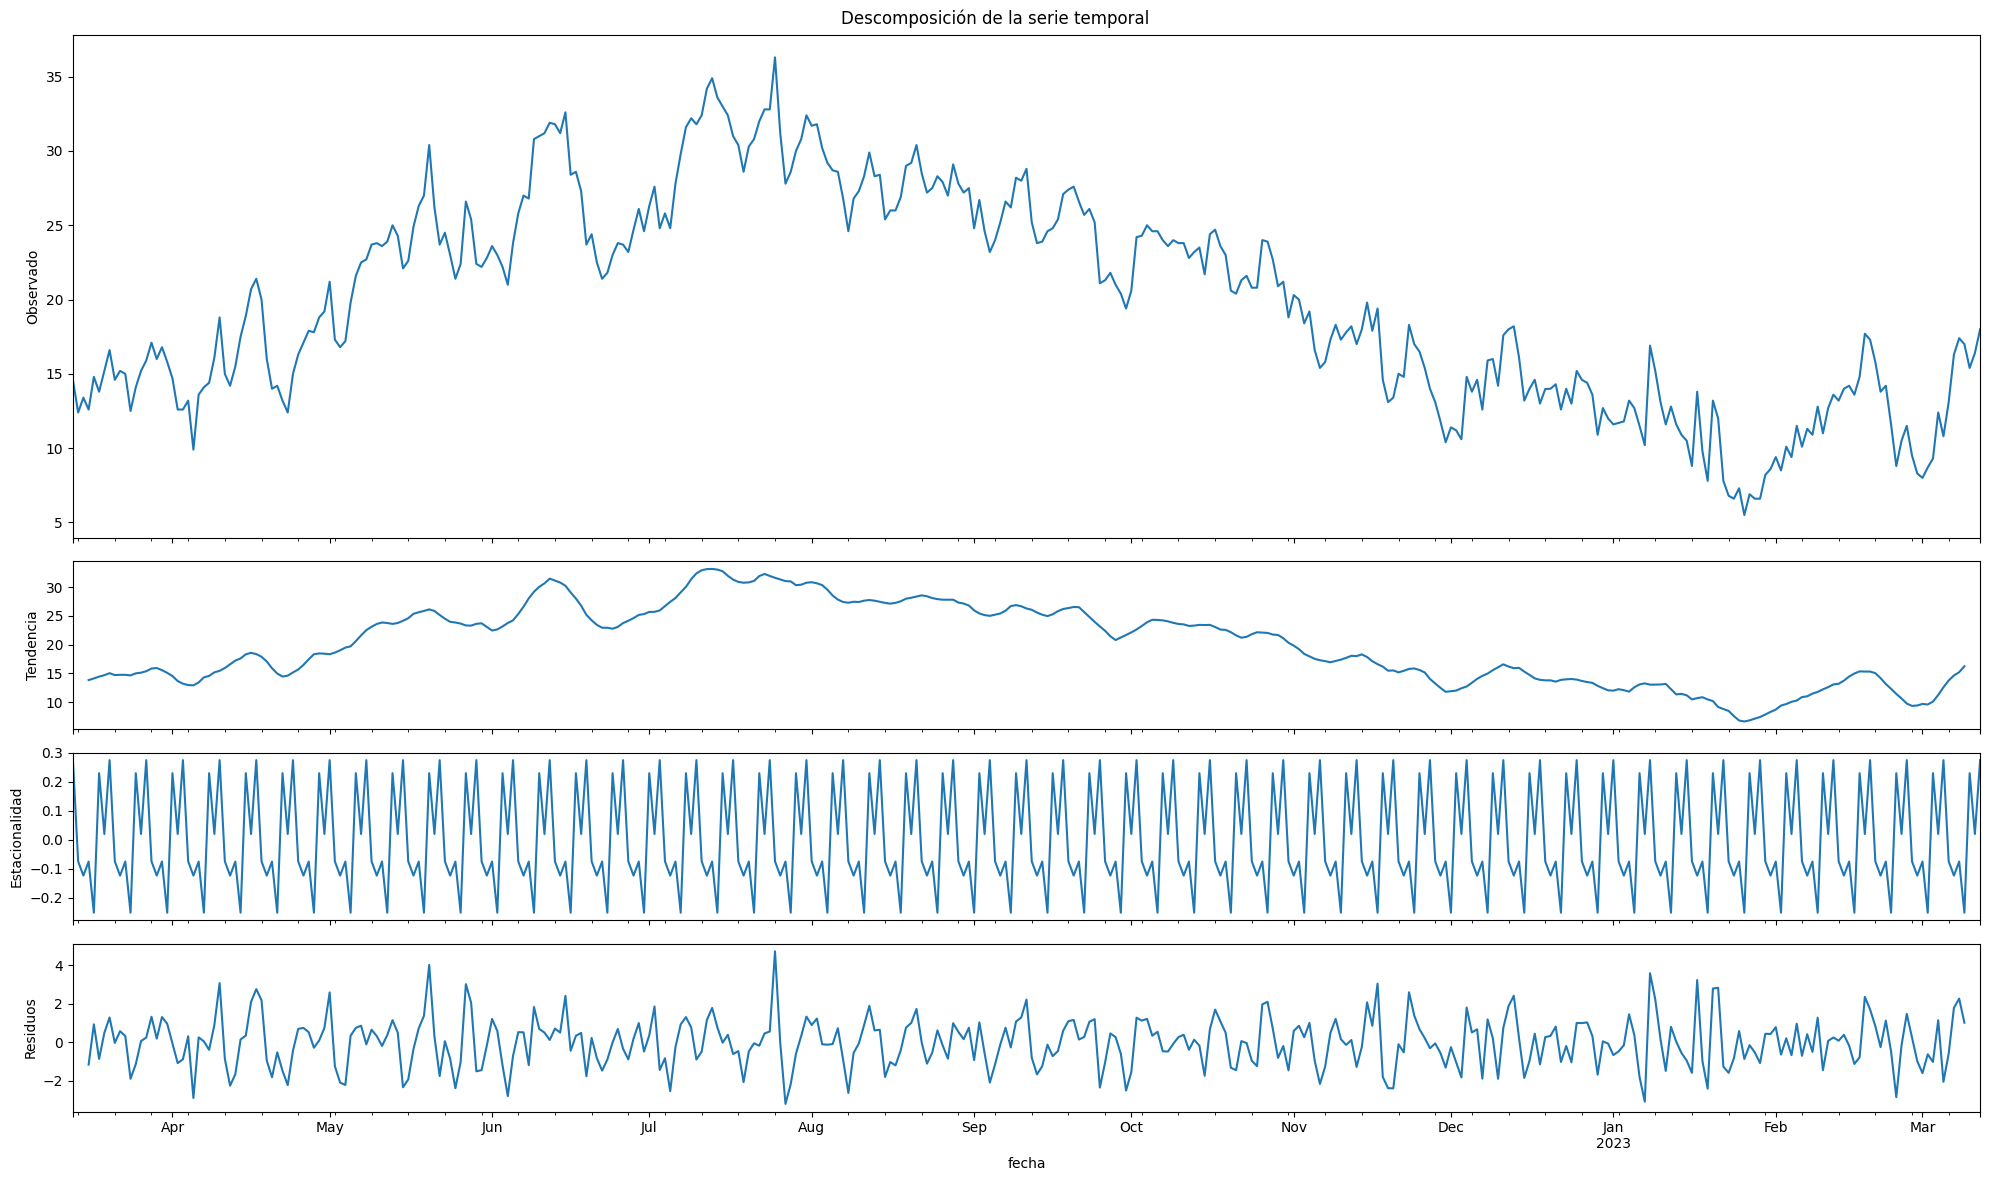

In [9]:
decompose_data = seasonal_decompose(tmed_last_year, model="additive")

# REESCALAR EL PLOT
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

decompose_data.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observado')

decompose_data.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Tendencia')

decompose_data.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Estacionalidad')

decompose_data.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residuos')

fig.suptitle('Descomposición de la serie temporal')

# Ajustar el espaciado entre las subplots
fig.tight_layout()

- No tiene tendencia
- Tiene estacionalidad

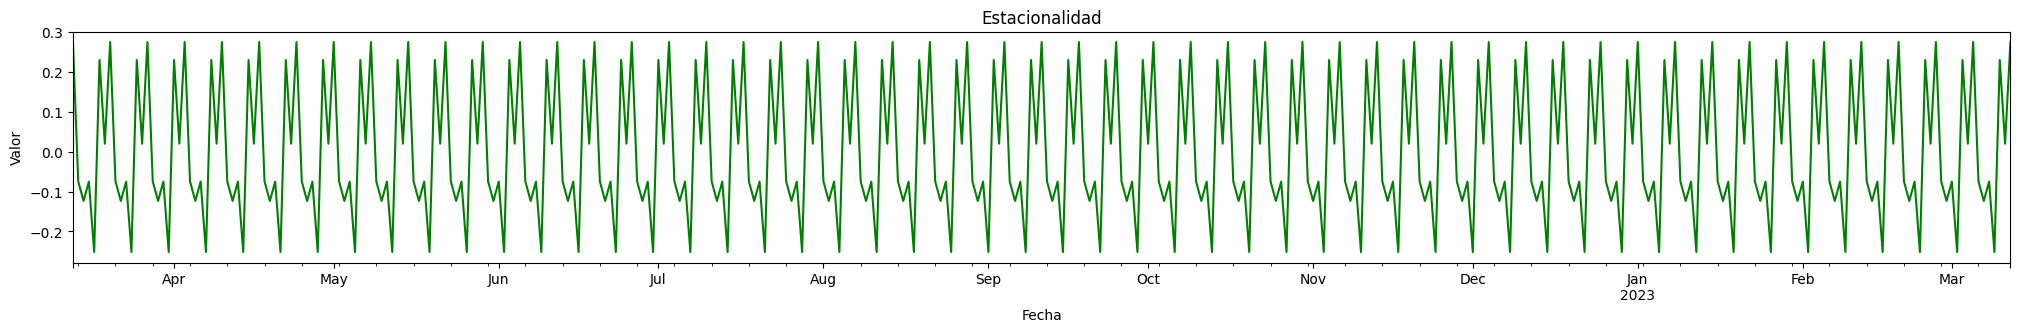

In [10]:
seasonality=decompose_data.seasonal
fig, ax = plt.subplots(figsize=(25, 3))
seasonality.plot(ax=ax, color='green')
ax.set_title('Estacionalidad')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')

# Mostrar el plot
plt.show()

### PRUEBA STL

Probamos a analizar viendo STL.

In [11]:
stl = STL(tmed_last_year, seasonal=13)
res = stl.fit()

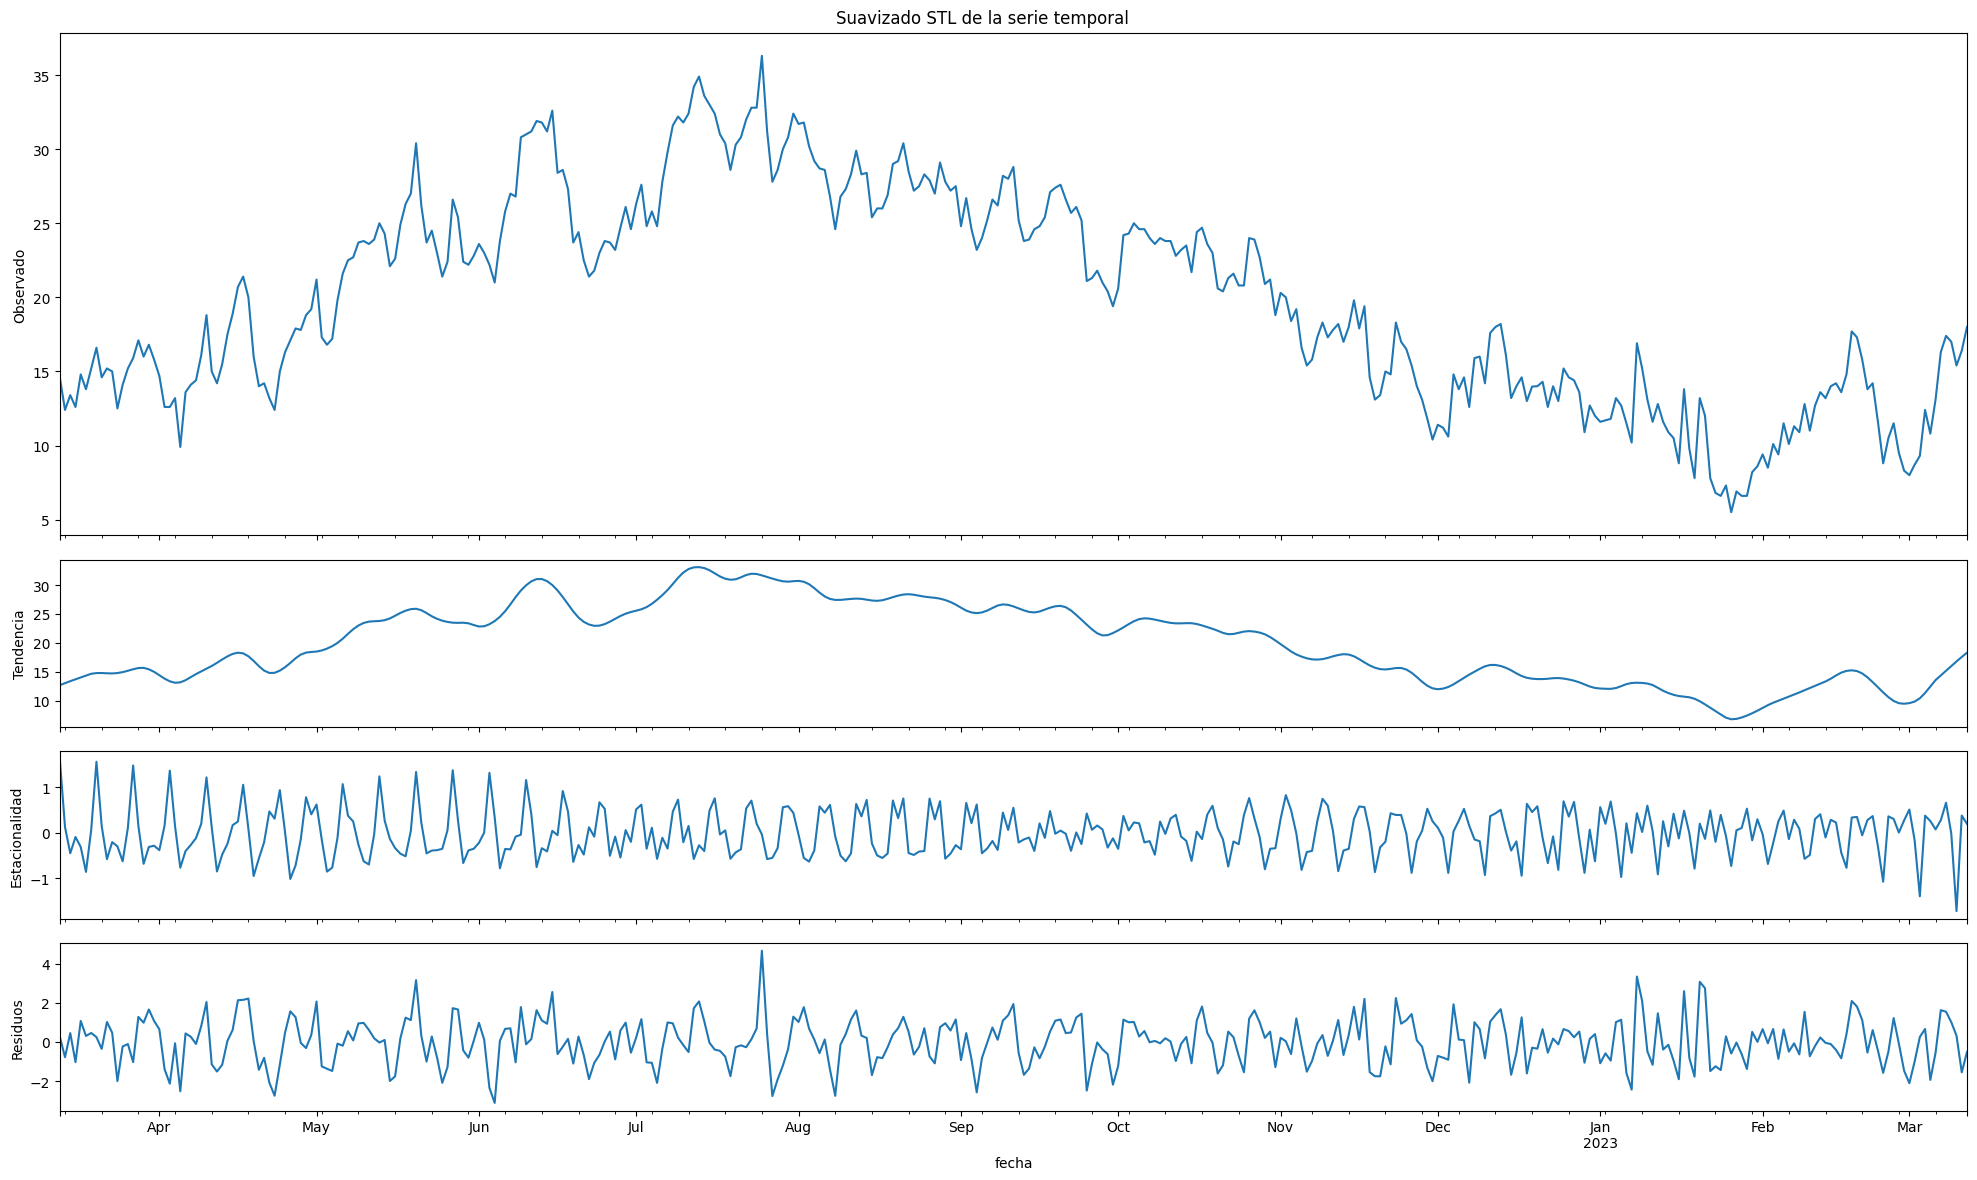

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

res.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observado')


res.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Tendencia')


res.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Estacionalidad')

res.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residuos')

fig.suptitle('Suavizado STL de la serie temporal')

# Ajustar el espaciado entre las subplots
fig.tight_layout()


- Superponemos para comparar

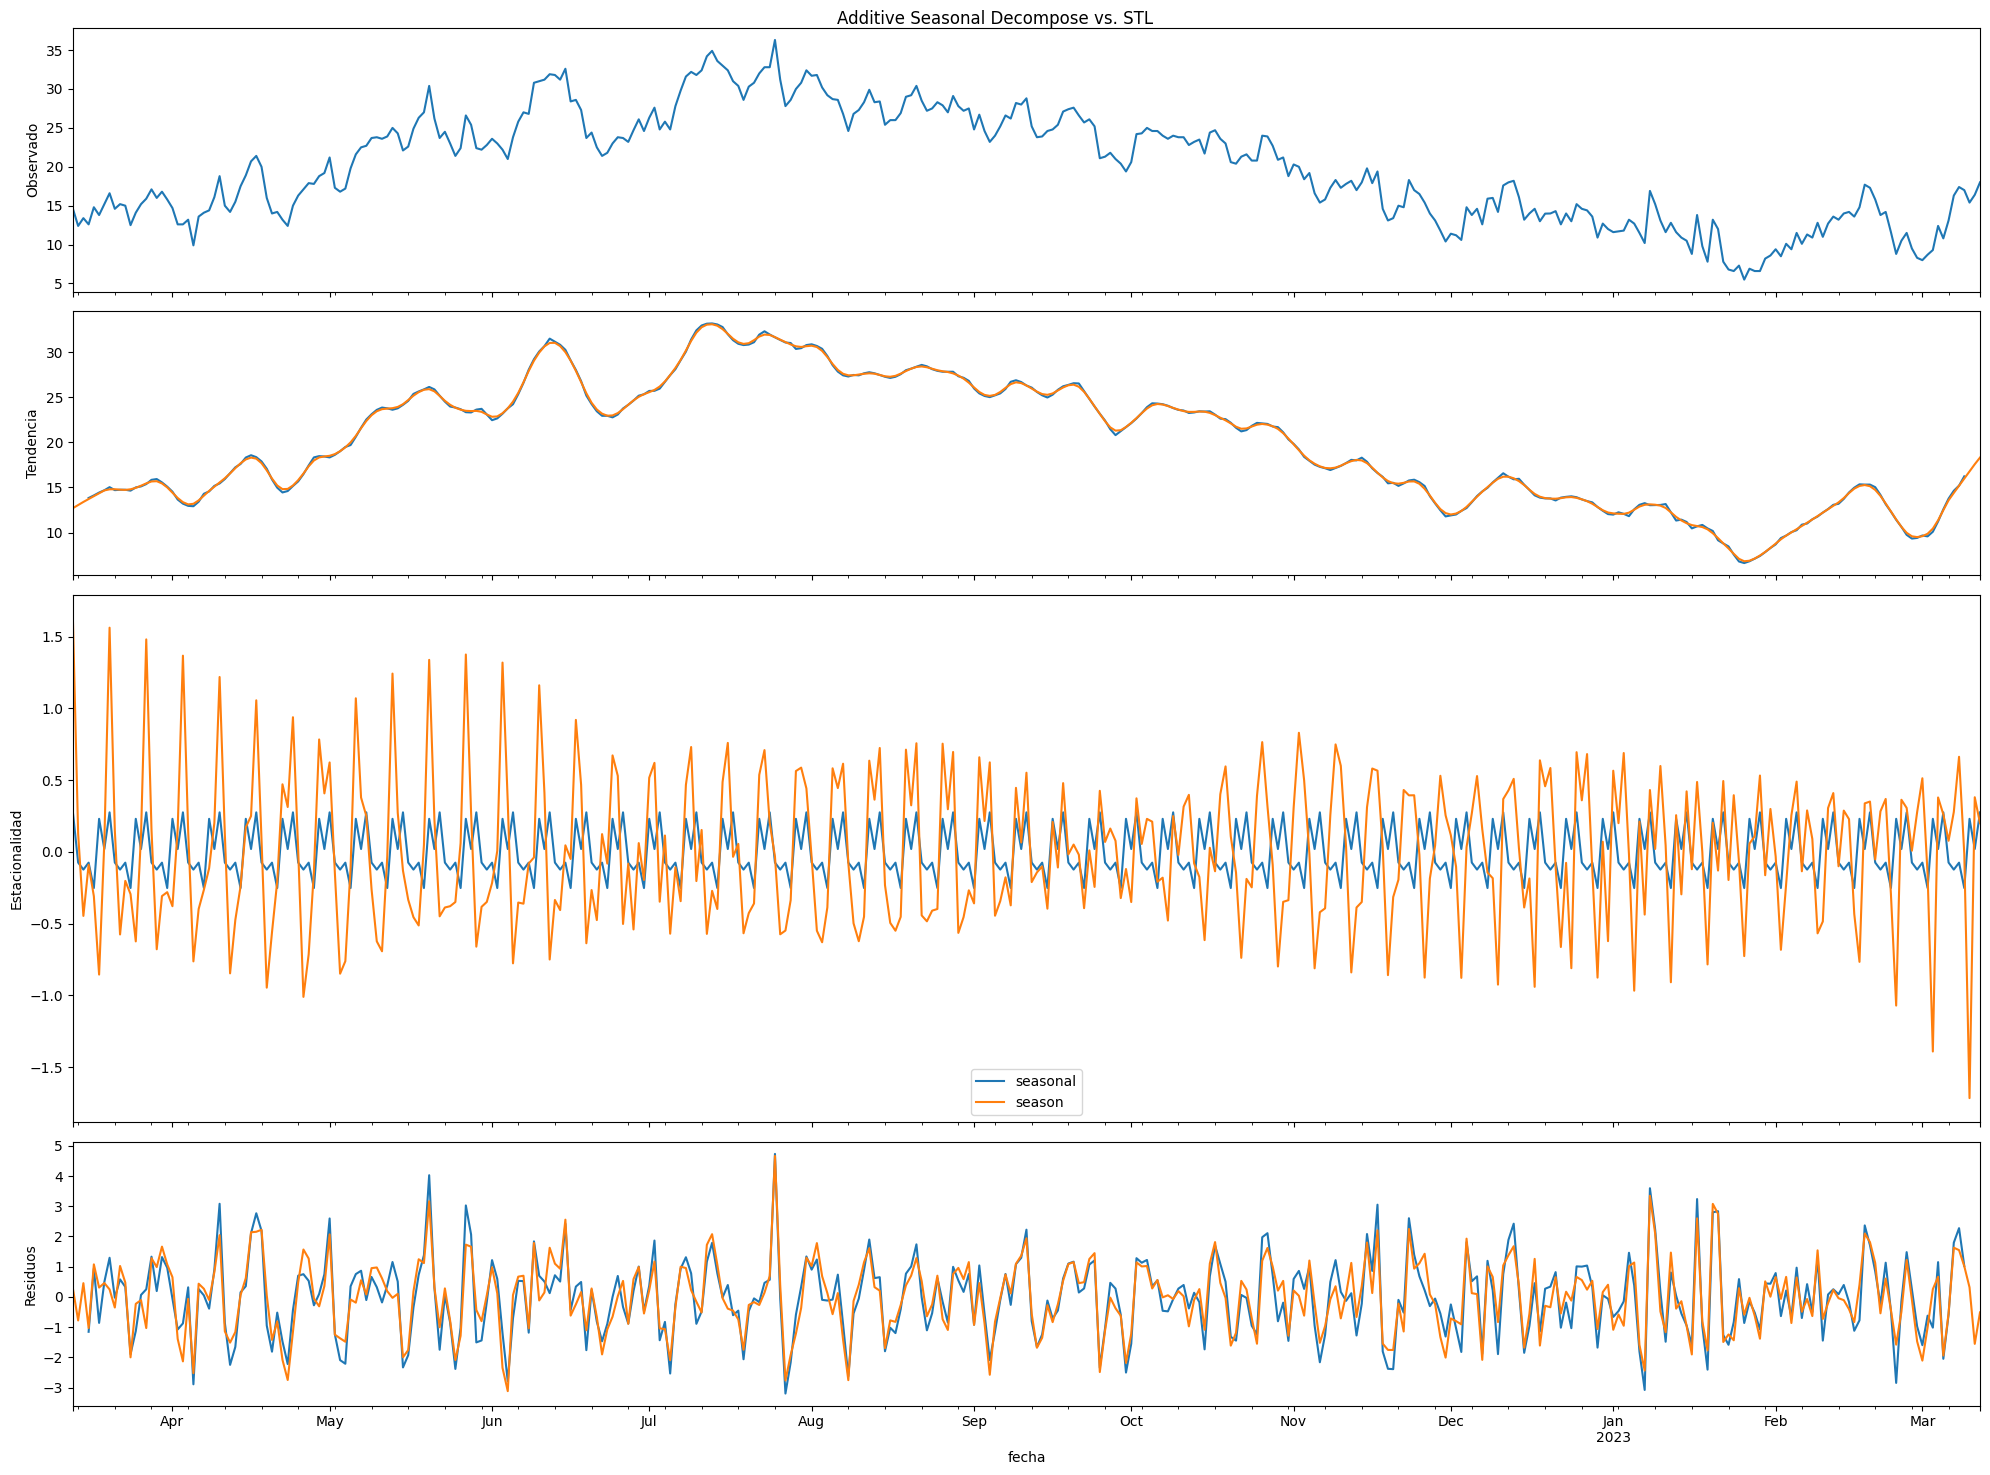

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 15), sharex=True, gridspec_kw={'height_ratios': [1, 1, 2, 1]})

res.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observado')

decompose_data.trend.plot(ax=axes[1], legend=False)
res.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Tendencia')


decompose_data.seasonal.plot(ax=axes[2], legend=False)
res.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Estacionalidad')
axes[2].legend(loc='lower center')

decompose_data.resid.plot(ax=axes[3], legend=False)
res.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residuos')

fig.suptitle('Additive Seasonal Decompose vs. STL')

# Ajustar el espaciado entre las subplots
fig.tight_layout()



ADFULLER

In [14]:
df_adf = adfuller(tmed, autolag = 'AIC')
print("1. ADF : ",df_adf[0])
print("2. P-Value : ", df_adf[1])
print("3. Num Of Lags : ", df_adf[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", df_adf[3])
print("5. Critical Values :")
for key, val in df_adf[4].items():
    print("\t",key, ": ", val)
print(f"Resultado: La serie es {'no' if df_adf[1] > 0.05 else ''}estacionaria")

1. ADF :  -8.594098639880185
2. P-Value :  7.154826175329938e-14
3. Num Of Lags :  40
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 12083
5. Critical Values :
	 1% :  -3.430891313396391
	 5% :  -2.861779232863024
	 10% :  -2.5668973386142
Resultado: La serie es estacionaria


KPSS

In [15]:
df_kpss = kpss(tmed)
print("1. KPSS : ",df_kpss[0])
print("2. P-Value : ", df_kpss[1])
print("3. Num Of Lags : ", df_kpss[2])
print("4. Critical Values :")
for key, val in df_kpss[3].items():
    print("\t",key, ": ", val)
print(f"Resultado: La serie es {'no' if df_kpss[1] < 0.05 else ''}estacionaria")

1. KPSS :  0.02587126548094913
2. P-Value :  0.1
3. Num Of Lags :  67
4. Critical Values :
	 10% :  0.347
	 5% :  0.463
	 2.5% :  0.574
	 1% :  0.739
Resultado: La serie es estacionaria


AUTOCORRELATION PLOT

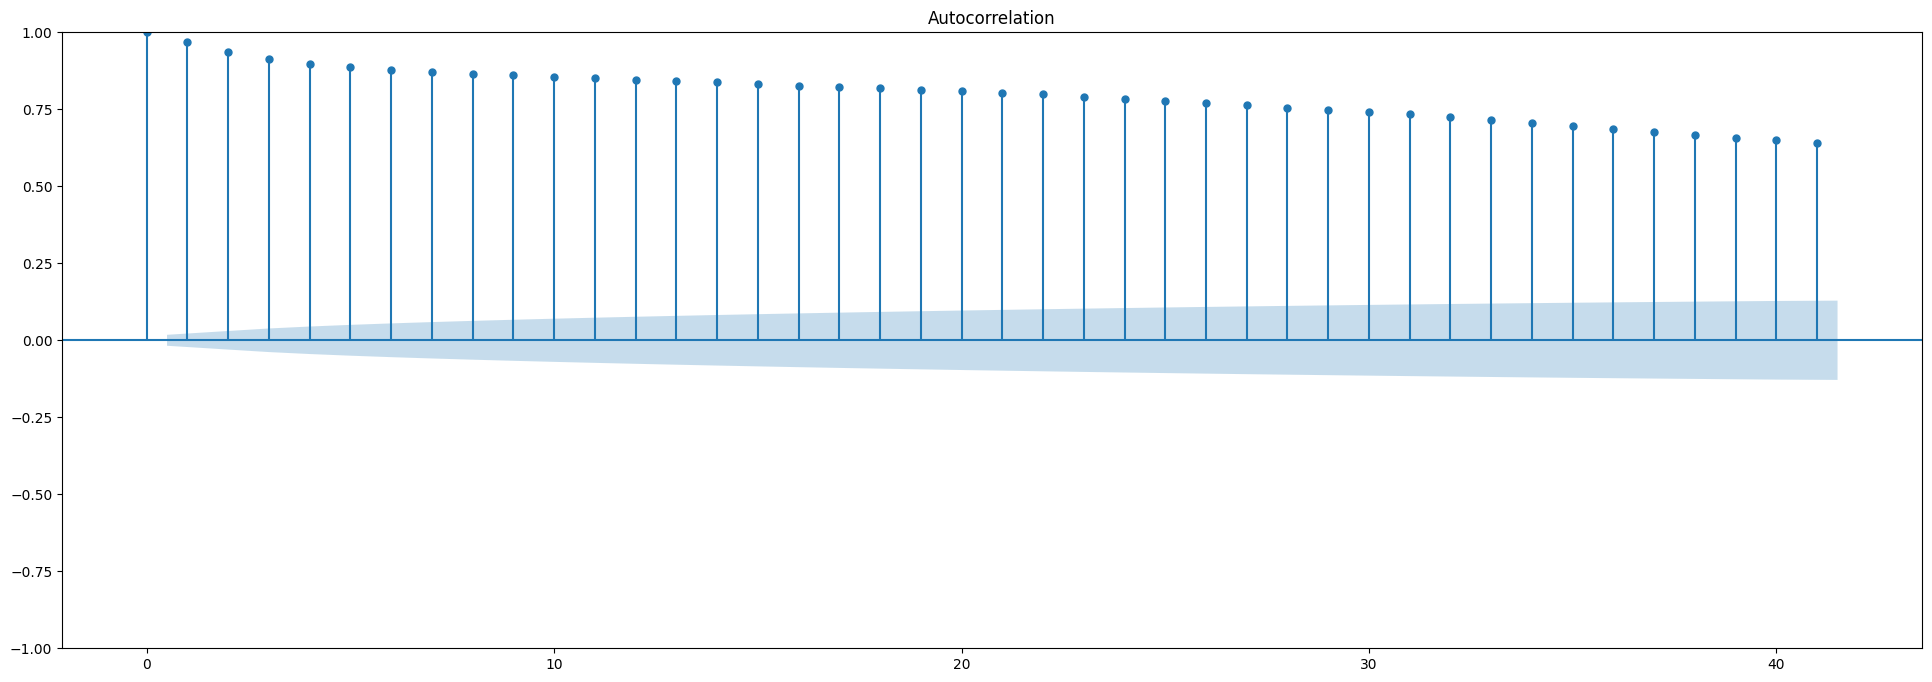

In [16]:
fig, ax = plt.subplots(figsize=(24, 8))
plot_acf(tmed, ax=ax)
plt.show()

- Poco podemos hacer aquí.

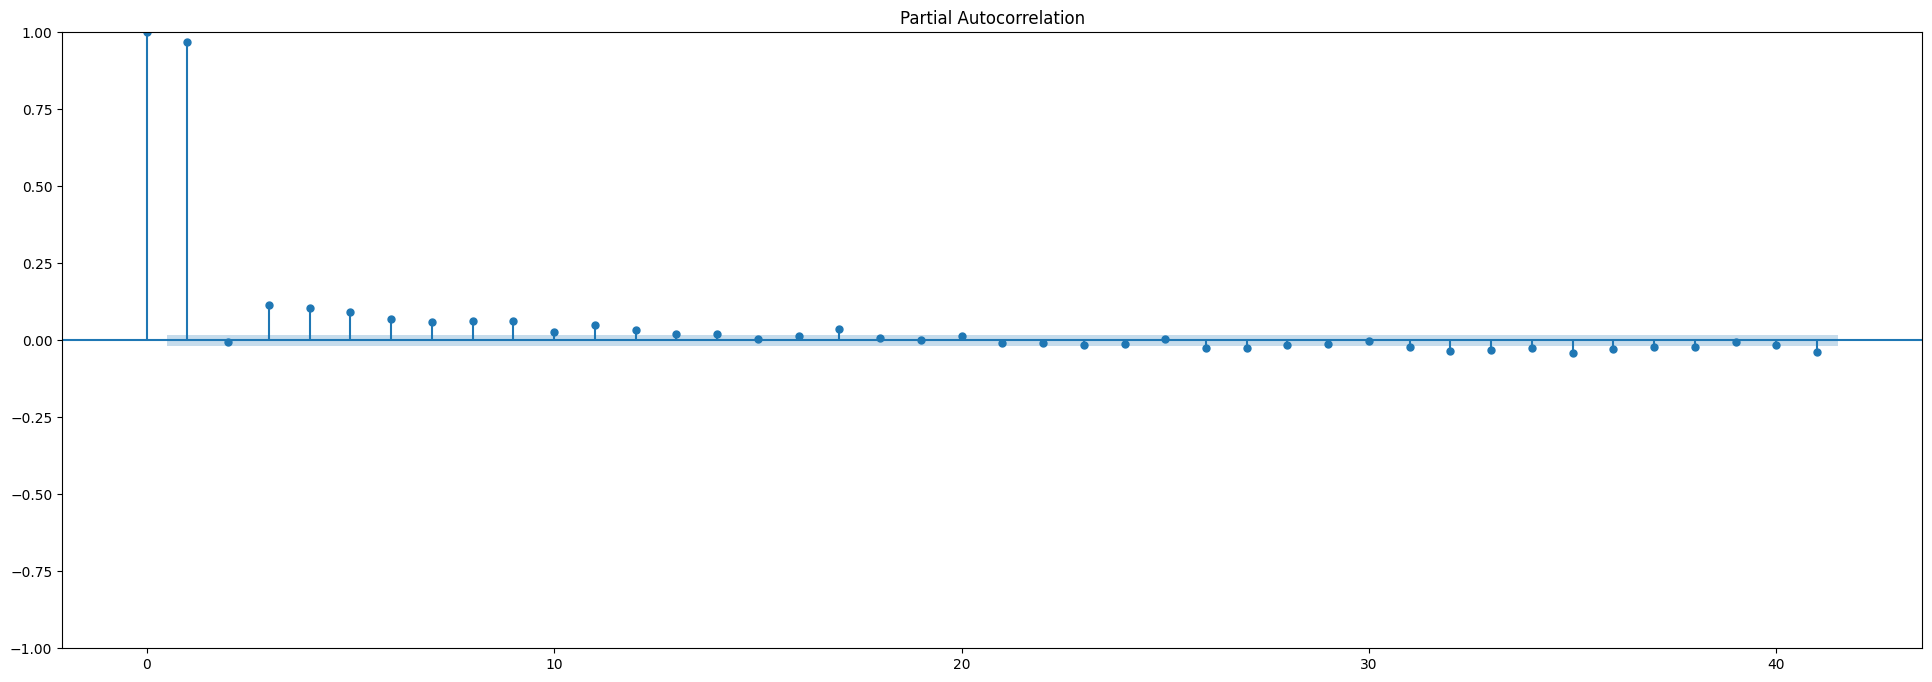

In [17]:
fig, ax = plt.subplots(figsize=(24, 8))
plot_pacf(tmed, ax=ax)
plt.show()

En el PACF vemos que el corte está en el retraso 3, con lo que su valor de `p` será = 2 en principio.

--- 
Veamos qué pasa al diferenciar.

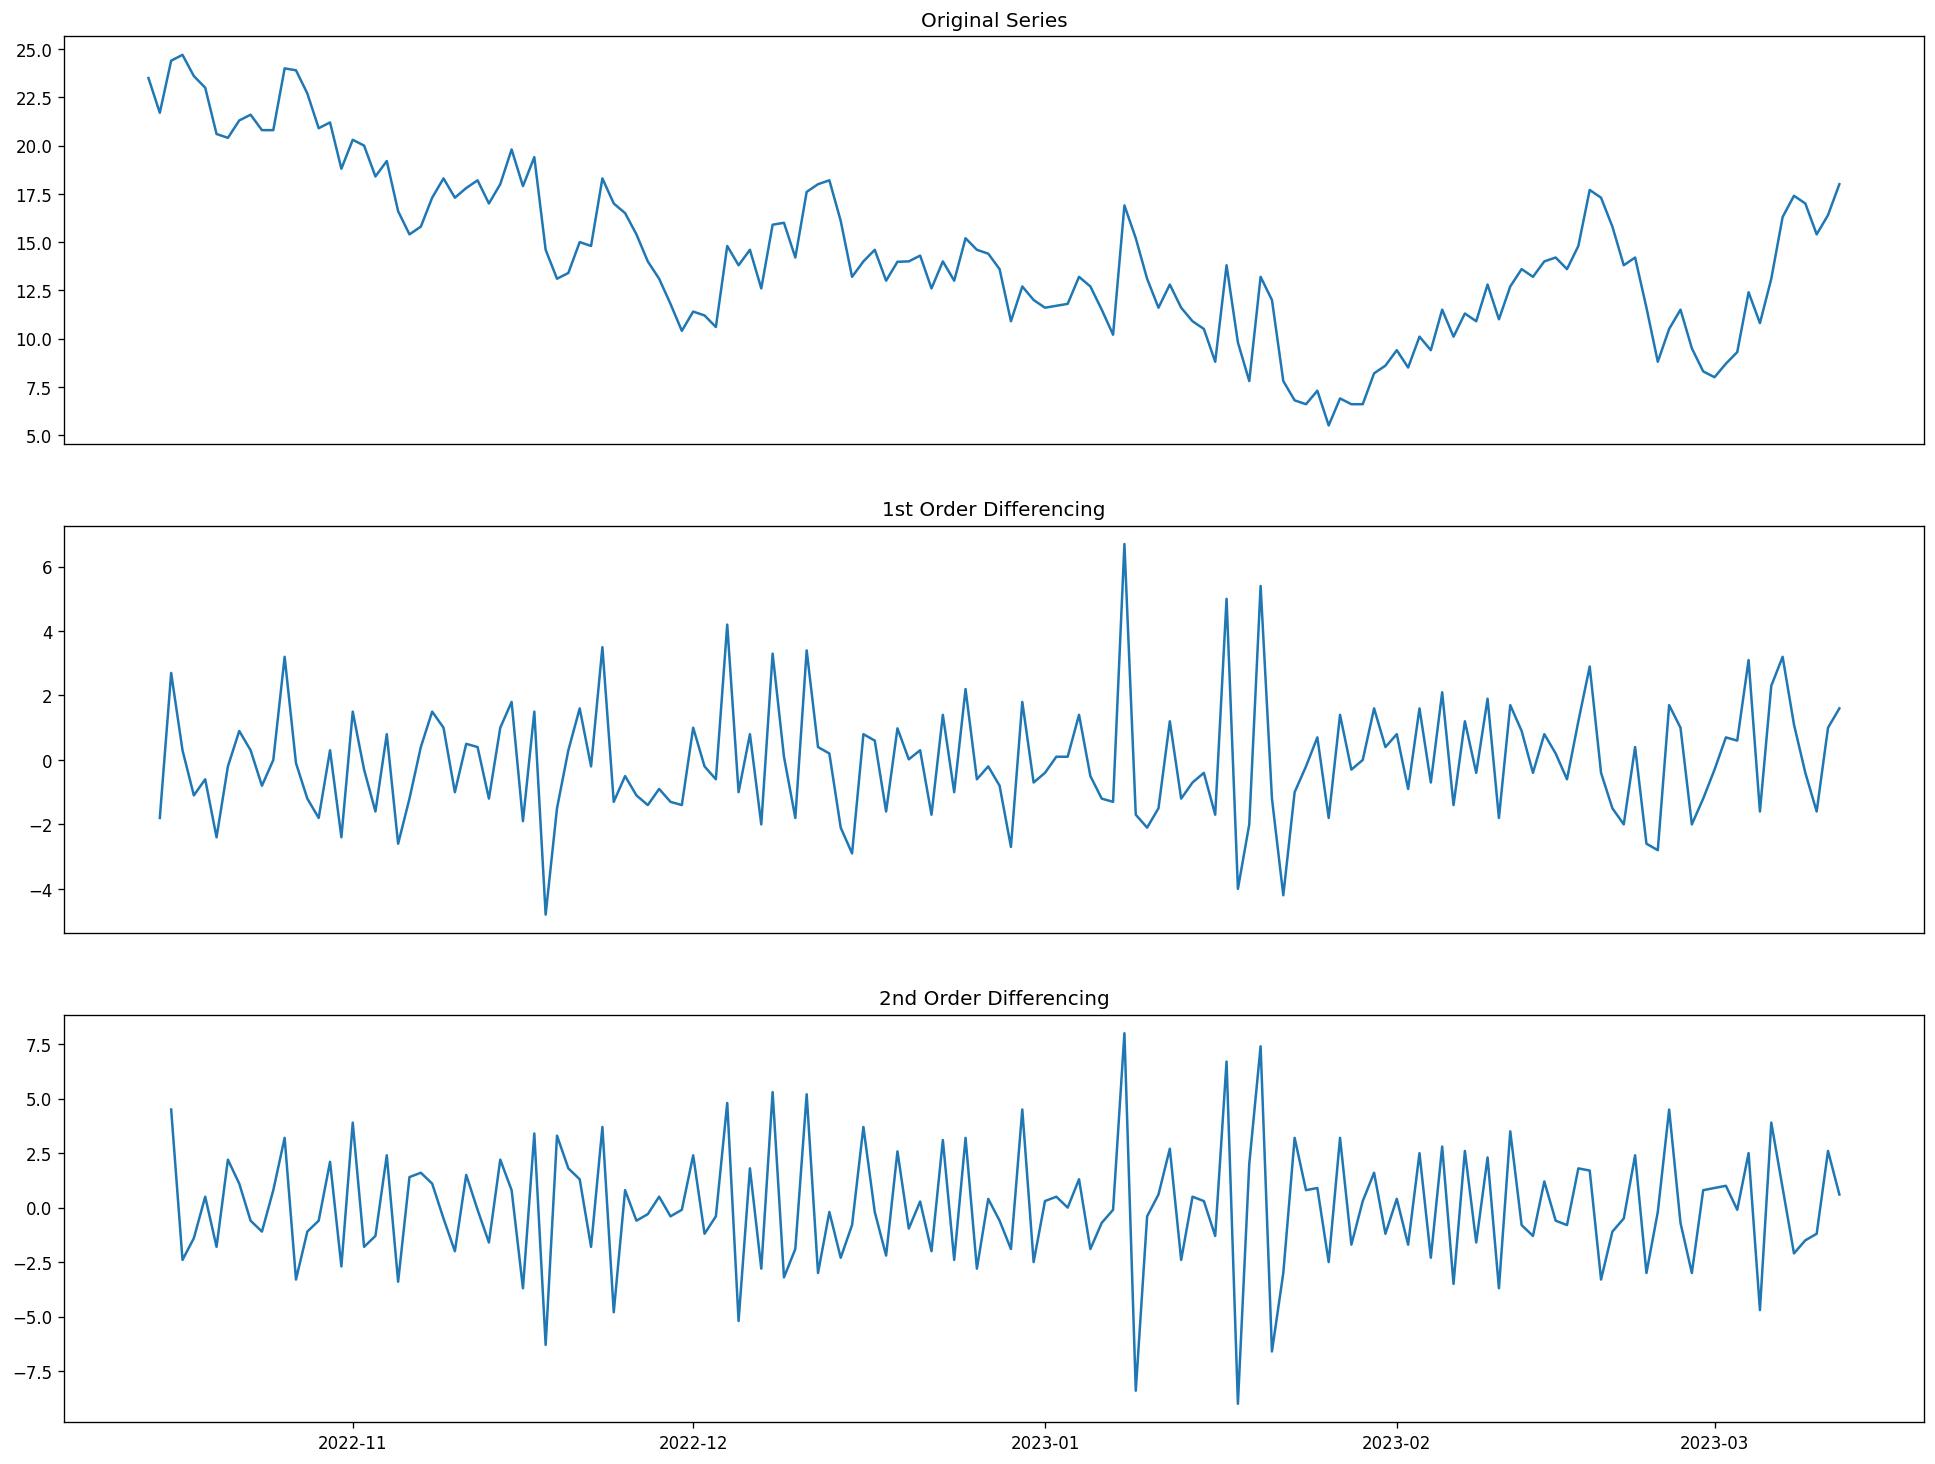

In [18]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})
axes[0].plot(tmed[-150:]); axes[0].set_title('Original Series'); axes[0].axes.xaxis.set_visible(False)
# 1st Differencing
axes[1].plot(tmed[-150:].diff()); axes[1].set_title('1st Order Differencing'); axes[1].axes.xaxis.set_visible(False)
# 2nd Differencing
axes[2].plot(tmed[-150:].diff().diff()); axes[2].set_title('2nd Order Differencing')
plt.show()

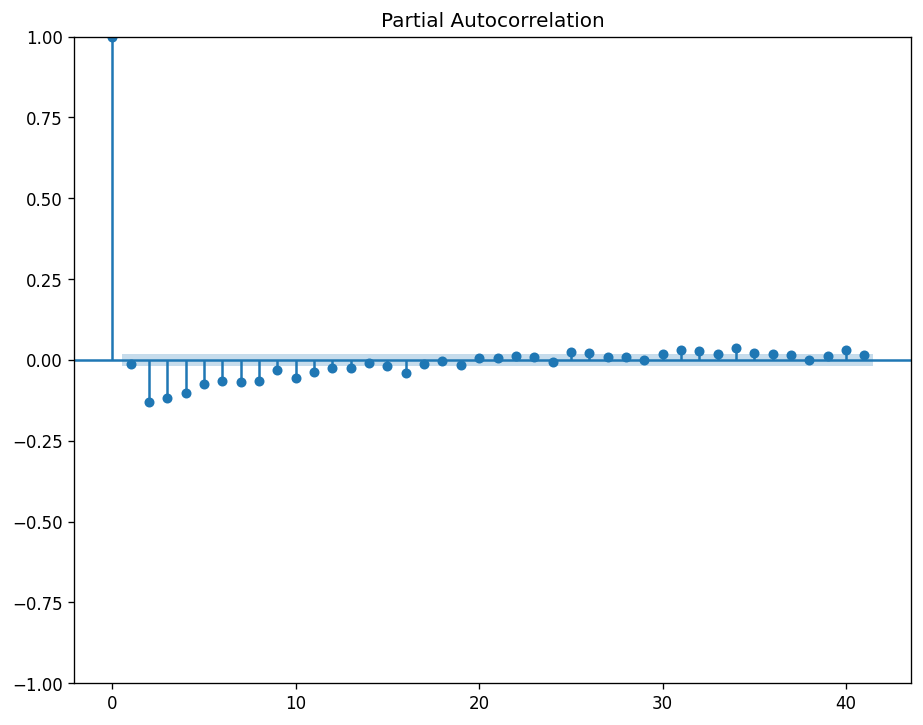

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(tmed.diff().dropna())
plt.show()

SEASONAL (ACF)

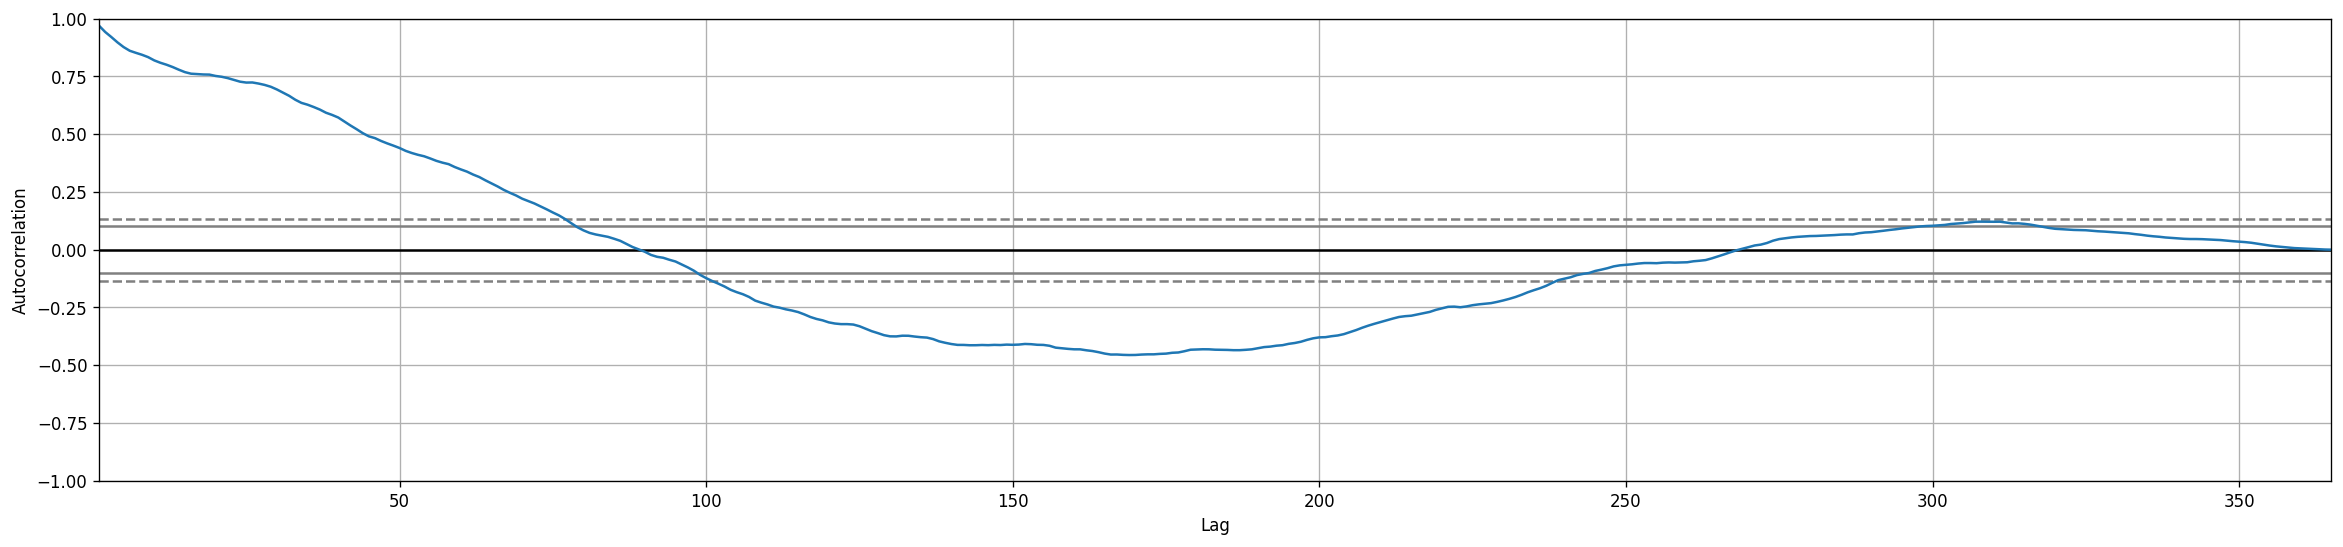

In [20]:
fig, ax = plt.subplots(figsize=(24, 5))
x = pd.plotting.autocorrelation_plot(tmed_last_year)
x.plot()
plt.show()

MA

In [21]:
q_values = range(1, 6)
d_values = range(3)

best_aic = float("inf")
best_params = None

tmed.index.freq = tmed.index.inferred_freq
for q, d in itertools.product(q_values, d_values):
    try:
        model = ARIMA(tmed, order=(q, d, 2))
        resultados_ma = model.fit()
        aic = resultados_ma.aic
        print("q = ", q, "d = ", d, "aic = ", aic)

        if aic < best_aic:
            best_model = resultados_ma
            best_aic = aic
            best_params = (q, d)

    except:
        continue

print("Los valores óptimos de q y d son:", best_params)


q =  1 d =  0 aic =  46777.66515435092
q =  1 d =  1 aic =  46397.0544662972
q =  1 d =  2 aic =  46583.1448277917


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


q =  2 d =  0 aic =  46377.723040000645
q =  2 d =  1 aic =  46382.002450756525


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


q =  2 d =  2 aic =  46395.26242129991


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


q =  3 d =  0 aic =  46258.51893185096
q =  3 d =  1 aic =  46387.86188686975
q =  3 d =  2 aic =  46987.22270319723


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


q =  4 d =  0 aic =  46190.746681753306
q =  4 d =  1 aic =  46385.478403203015


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


q =  4 d =  2 aic =  46769.494112195665
q =  5 d =  0 aic =  46358.90751139251
q =  5 d =  1 aic =  46387.25620594606
q =  5 d =  2 aic =  46701.69941562935
Los valores óptimos de q y d son: (4, 0)


In [22]:
predicciones_ma = best_model.predict(start=len(tmed)-7, end=len(tmed)-1)

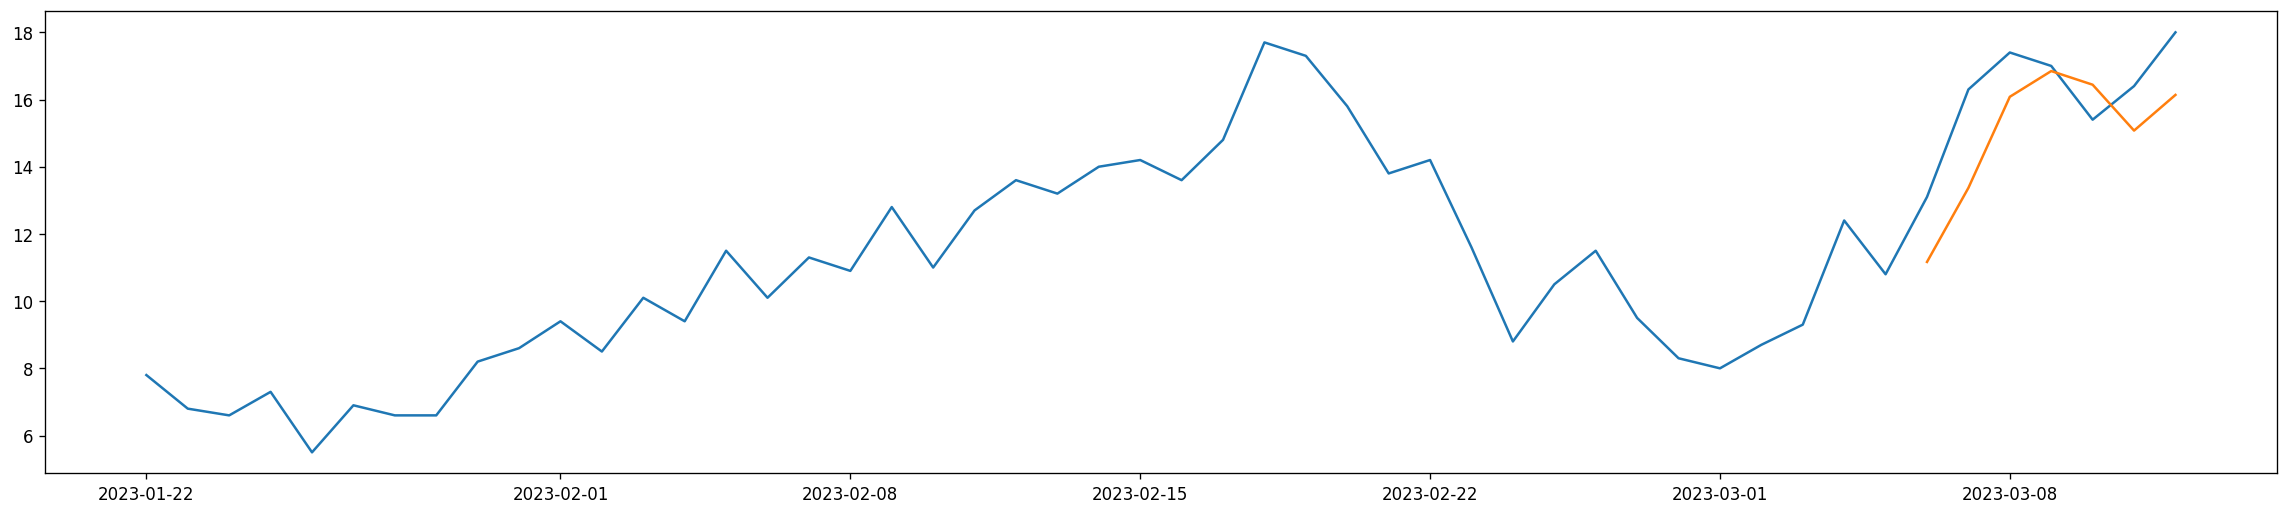

In [26]:
plt.subplots(figsize=(24, 5))
plt.plot(tmed[-50:])
plt.plot(predicciones_ma)
plt.show()

No vale porque está haciendo lo mismo que el día anterior

ARIMA + STL

Usamos MSE para darle más peso a errores grandes

In [24]:
from statsmodels.tsa.forecasting.stl import STLForecast
from sklearn.metrics import mean_squared_error
import itertools

p_values = range(1, 6)
q_values = range(1, 6)
d_values = range(3)

best_mse = float("inf")
best_params = None
best_forecast = None

tmed.index.freq = tmed.index.inferred_freq
iteration = 0

for p, q, d in itertools.product(p_values, q_values, d_values):
    try:
        stlf = STLForecast(
            tmed, ARIMA, model_kwargs=dict(order=(p, d, q), trend="t")
        )
        stlf_res = stlf.fit()
        mse = mean_squared_error(tmed[-15:], stlf_res.forecast(15))
        iteration += 1
        print(f"Iteration {iteration}: p={p}, d={d}, q={q}, MSE={mse}")
        if mse < best_mse:
            best_mse = mse
            best_params = (p, d, q)
            best_model = stlf_res
            best_forecast = stlf_res.forecast(15)
    except:
        continue

print(f"Best MSE: {best_mse}")
print(f"Best Parameters: {best_params}")

Iteration 1: p=1, d=0, q=1, MSE=36.39460659632068
Iteration 2: p=1, d=1, q=1, MSE=24.032424925152
Iteration 3: p=1, d=0, q=2, MSE=34.921604216915306
Iteration 4: p=1, d=1, q=2, MSE=23.3075459343017
Iteration 5: p=1, d=0, q=3, MSE=34.55354997389743
Iteration 6: p=1, d=1, q=3, MSE=23.329994819232038
Iteration 7: p=1, d=0, q=4, MSE=32.119697360788926
Iteration 8: p=1, d=1, q=4, MSE=23.21783741464612


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 9: p=1, d=0, q=5, MSE=19.585741809660092


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 10: p=1, d=1, q=5, MSE=21.481021222849527


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 11: p=2, d=0, q=1, MSE=35.020107309171756
Iteration 12: p=2, d=1, q=1, MSE=23.143248241927424


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 13: p=2, d=0, q=2, MSE=28.66457813573108


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 14: p=2, d=1, q=2, MSE=24.361570066936828
Iteration 15: p=2, d=0, q=3, MSE=34.69105973692533


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration 16: p=2, d=1, q=3, MSE=22.94700557436215


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 17: p=2, d=0, q=4, MSE=31.637697869111882
Iteration 18: p=2, d=1, q=4, MSE=27.2298591464036


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 19: p=2, d=0, q=5, MSE=18.377316496566287


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 20: p=2, d=1, q=5, MSE=16.866501917251814


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 21: p=3, d=0, q=1, MSE=35.28551483479766
Iteration 22: p=3, d=1, q=1, MSE=23.305520729626426


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 23: p=3, d=0, q=2, MSE=26.459779732416955


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration 24: p=3, d=1, q=2, MSE=22.842456942810202


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 25: p=3, d=0, q=3, MSE=34.00936634606995


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 26: p=3, d=1, q=3, MSE=20.511398850158685


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 27: p=3, d=0, q=4, MSE=26.491435548176124


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 28: p=3, d=1, q=4, MSE=22.172928680467702


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 29: p=3, d=0, q=5, MSE=16.178573153559466


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 30: p=3, d=1, q=5, MSE=22.02486526276919


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 31: p=4, d=0, q=1, MSE=34.158753146728216
Iteration 32: p=4, d=1, q=1, MSE=31.499077448461794


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 33: p=4, d=0, q=2, MSE=19.400983119644653


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration 34: p=4, d=1, q=2, MSE=23.7003093532529


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 35: p=4, d=0, q=3, MSE=29.840340800486356


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 36: p=4, d=1, q=3, MSE=21.003375694800102


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 37: p=4, d=0, q=4, MSE=23.80168281868836


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 38: p=4, d=1, q=4, MSE=21.063264670796162


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 39: p=4, d=0, q=5, MSE=25.106175858180215


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 40: p=4, d=1, q=5, MSE=22.899690913240043
Iteration 41: p=5, d=0, q=1, MSE=34.94235449778559
Iteration 42: p=5, d=1, q=1, MSE=31.621584575354436


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 43: p=5, d=0, q=2, MSE=29.84602398489258
Iteration 44: p=5, d=1, q=2, MSE=21.25758536072516


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 45: p=5, d=0, q=3, MSE=33.89503487511754


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 46: p=5, d=1, q=3, MSE=27.64763186292937


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 47: p=5, d=0, q=4, MSE=28.830448962305137


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 48: p=5, d=1, q=4, MSE=23.784066312119457


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 49: p=5, d=0, q=5, MSE=27.175562644736537


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration 50: p=5, d=1, q=5, MSE=28.717918477243668
Best MSE: 16.178573153559466
Best Parameters: (3, 0, 5)


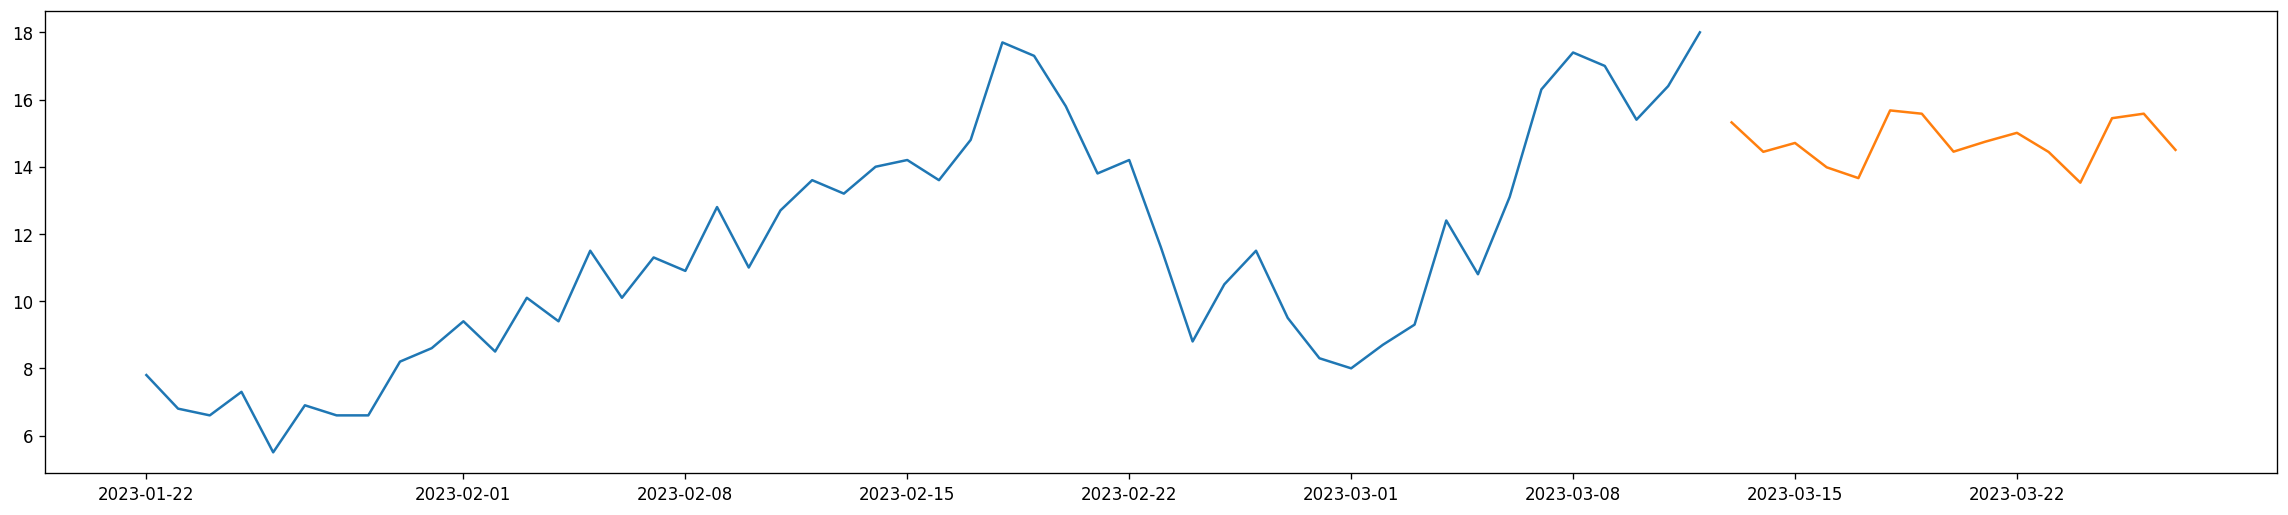

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                12124
Model:                 ARIMA(3, 0, 5)   Log Likelihood              -19592.315
Date:                Sat, 18 Mar 2023   AIC                          39204.629
Time:                        01:14:19   BIC                          39278.658
Sample:                    01-01-1990   HQIC                         39229.450
                         - 03-12-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0011      0.001      1.148      0.251      -0.001       0.003
ar.L1          1.0533      0.009    121.723      0.000       1.036       1.070
ar.L2         -0.4582      0.013    -34.645      0.0

In [39]:
plt.subplots(figsize=(24, 5))
plt.plot(tmed[-50:])
plt.plot(best_model.forecast(15))
plt.show()
print(best_model.summary())


------

Teniendo un ARIMA 3-0-5, vamos a probar SARIMAX con esos parámetros + exógenas

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

import warnings
warnings.filterwarnings('ignore')

def sarimax(ts,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

In [28]:
exo = df_base.drop('tmed', axis=1)

In [31]:
p, d, q = [3], [0], [5]
P, D, Q, s = range(0, 5), [0], range(0, 5), [7]

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

all_res = sarimax(tmed, exo, all_param)

Tried out SARIMAX(3, 0, 5)x(0, 0, 0, 7) - AIC:-48481.65
Tried out SARIMAX(3, 0, 5)x(0, 0, 1, 7) - AIC:-48479.39
Tried out SARIMAX(3, 0, 5)x(0, 0, 2, 7) - AIC:-48477.19
Tried out SARIMAX(3, 0, 5)x(0, 0, 3, 7) - AIC:-48475.32
Tried out SARIMAX(3, 0, 5)x(0, 0, 4, 7) - AIC:-48473.21
Tried out SARIMAX(3, 0, 5)x(1, 0, 0, 7) - AIC:-48479.45
Tried out SARIMAX(3, 0, 5)x(1, 0, 1, 7) - AIC:-48477.34
Tried out SARIMAX(3, 0, 5)x(1, 0, 2, 7) - AIC:-48475.16
Tried out SARIMAX(3, 0, 5)x(1, 0, 3, 7) - AIC:-48473.34
Tried out SARIMAX(3, 0, 5)x(1, 0, 4, 7) - AIC:-48471.2
Tried out SARIMAX(3, 0, 5)x(2, 0, 0, 7) - AIC:-48477.58
Tried out SARIMAX(3, 0, 5)x(2, 0, 1, 7) - AIC:-48475.54
Tried out SARIMAX(3, 0, 5)x(2, 0, 2, 7) - AIC:-48472.9
Tried out SARIMAX(3, 0, 5)x(2, 0, 3, 7) - AIC:-48471.37
Tried out SARIMAX(3, 0, 5)x(2, 0, 4, 7) - AIC:-48469.2
Tried out SARIMAX(3, 0, 5)x(3, 0, 0, 7) - AIC:-48475.71
Tried out SARIMAX(3, 0, 5)x(3, 0, 1, 7) - AIC:-48473.66
Tried out SARIMAX(3, 0, 5)x(3, 0, 2, 7) - AIC:-4847

In [34]:
all_res.sort(key=lambda x: x[1])
all_res[0]

(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2a8f10176c8>,
 -48481.651912501686,
 ((3, 0, 5), (0, 0, 0, 7)))

- Saquemos el modelo para estos parámetros y veamos

In [38]:
model = SARIMAX(tmed, exog=exo, order=(3, 0, 5), seasonal_order=(0, 0, 0, 7))
resultado = model.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   tmed   No. Observations:                12124
Model:               SARIMAX(3, 0, 5)   Log Likelihood               24258.826
Date:                Sat, 18 Mar 2023   AIC                         -48481.652
Time:                        01:13:26   BIC                         -48348.399
Sample:                    01-01-1990   HQIC                        -48436.975
                         - 03-12-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tmin           0.5002      0.000   3416.198      0.000       0.500       0.500
tmax           0.4998      0.000   3773.335      0.000       0.500       0.500
presMin        0.0002      0.000      1.216      0.224      -0.000       0.001
presMax       -0.0002      0.000     -1.189      0.234      -0.001       0.000
dir        -1.703e-05   1.03e-05     -1.647      0.100   -3.73e-05    3.23e-06
velmedia    3.695e-05      0.000      0.116      0.908      -0.001       0.001
racha         -0.0001      0.000     -0.789      0.430      -0.000       0.000
sol            0.0001      0.000      1.030      0.303      -0.000       0.000
prec       -2.569e-06   6.98e-05     -0.037      0.971      -0.000       0.000
ar.L1         -1.4255      0.515     -2.767      0.006      -2.435      -0.416
ar.L2         -1.1529      0.608     -1.897      0.058      -2.344       0.038
ar.L3         -0.2172      0.470     -0.462      0.644      -1.139       0.705
ma.L1          1.4340      0.515      2.784      0.005       0.424       2.444
ma.L2          1.1674      0.612      1.908      0.056      -0.032       2.366
ma.L3          0.2416      0.475      0.509      0.611      -0.690       1.173
ma.L4          0.0306      0.016      1.876      0.061      -0.001       0.063
ma.L5          0.0196      0.010      1.965      0.049    4.68e-05       0.039
sigma2         0.0011    6.6e-06    162.271      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             94320.52
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Mejoramos los datos. Entrenamos el modelo.